In [191]:
import numpy as np
import pandas as pd
import xarray as xr

import plotting_utils as pu
import sa_city_utils as sacu

from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, trend_metric_ids
from utils import city_list

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [192]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 11
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

## Useful plotting functions

In [3]:
def plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, limits=None, store=True, legend=0, read_samples=True):
    # Make axes
    fig, axs = plt.subplots(2, len(metric_ids), height_ratios=[4, 1], figsize=(4*len(metric_ids),11))
    time_str = f"{proj_slice} relative to {hist_slice}" if "diff" in plot_col else f"{proj_slice}"
    fig.suptitle(f"{pu.city_names[city]} ({time_str})", fontweight='bold')

    # Loop through examples
    for idx, metric_id in enumerate(metric_ids):
        axs_subset = axs[:,idx]

        pu.plot_city_results(
            city = city,
            metric_id = metric_id,
            plot_col = plot_col,
            hist_slice = hist_slice,
            proj_slice = proj_slice,
            fit_method = fit_method,
            stationary = stationary,
            axs = axs_subset,
            read_samples = read_samples,
            limits = limits[idx] if type(limits) == list else None,
            yticklabels = True if idx == 0 else False,
            legend = True if idx == legend else False,
        )

    plt.tight_layout()
    
    if store:
        plt.savefig(f'../figs/{city}_{plot_col}_{fit_method}_{stationary}_{hist_slice}_{proj_slice}.pdf')
    else:
        plt.show()

## Plots

### Timeseries

In [51]:
# Read timeseries
city = "chicago"
metric_id = "max_tasmax"
var_id = metric_id.split('_')[1]

# Read raw
df = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Drop TaiESM1
df = df[df['gcm'] != 'TaiESM1']

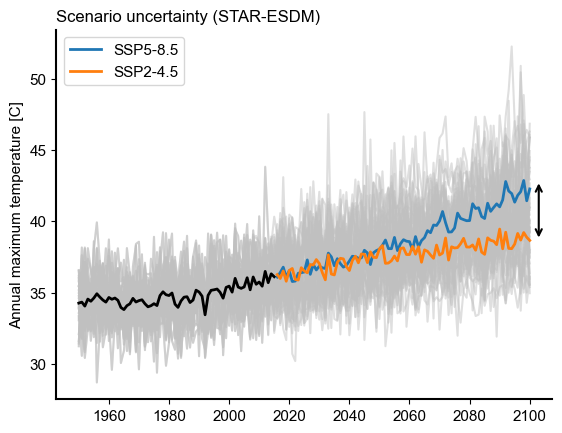

In [114]:
## Plot 1: scenario uncertainty
ensemble = 'STAR-ESDM'
df_ssp245 = df[(df['ssp'] == 'ssp245') & (df['ensemble'] == ensemble)]
df_ssp585 = df[(df['ssp'] == 'ssp585') & (df['ensemble'] == ensemble)]

fig, ax = plt.subplots()

# Plot all
for df_plot in [df_ssp245, df_ssp585]:
    for gcm in df_plot['gcm'].unique():
        df_plot_sel = df_plot[df_plot['gcm'] == gcm].sort_values('time')
        ax.plot(df_plot_sel['time'], df_plot_sel[var_id], color='silver', alpha=0.5)

# Plot means
df_ssp245.query('time <= 2015').groupby('time').mean(numeric_only=True).plot(y='tasmax', legend=None, color='black', lw=2, ax=ax)
df_ssp585.query('time > 2015').groupby('time').mean(numeric_only=True).plot(y='tasmax', label='SSP5-8.5', lw=2, ax=ax)
df_ssp245.query('time > 2015').groupby('time').mean(numeric_only=True).plot(y='tasmax', label='SSP2-4.5', lw=2, ax=ax)

# Tidy
ax.set_xlabel('')
ax.set_ylabel('Annual maximum temperature [C]')
ax.set_title('Scenario uncertainty (STAR-ESDM)', loc='left', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)

# Add index of scenario uncertainty
y1 = df_ssp245.query('time > 2015').groupby('time').mean(numeric_only=True)[var_id].iloc[-5:].min()
y2 = df_ssp585.query('time > 2015').groupby('time').mean(numeric_only=True)[var_id].iloc[-5:].max()
ax.annotate('', xy=(2103, y1), xytext=(2103, y2),
            textcoords='data',
            arrowprops=dict(arrowstyle='<->', lw=1.5))

plt.show()

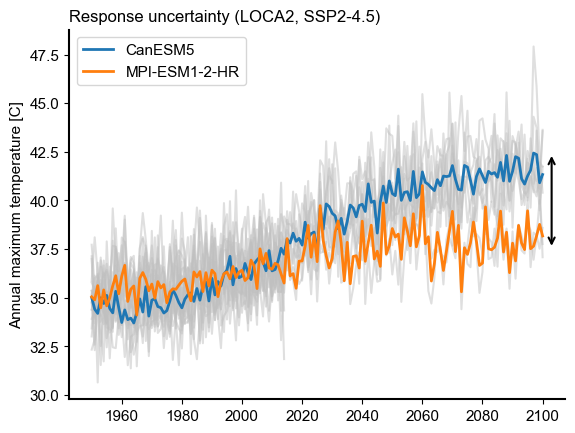

In [257]:
## Plot 2: response uncertainty
ensemble = 'LOCA2'
ssp = 'ssp245'
ssp_name = pu.ssp_labels[ssp]
gcm1 = 'CanESM5'
gcm2 = 'MPI-ESM1-2-HR'

df_gcm1 = df[(df['ssp'].isin([ssp, 'historical'])) & (df['ensemble'] == ensemble) & (df['gcm'] == gcm1)]
df_gcm2 = df[(df['ssp'].isin([ssp, 'historical'])) & (df['ensemble'] == ensemble) & (df['gcm'] == gcm2)]

fig, ax = plt.subplots()

# Plot all
for df_plot in [df_gcm1, df_gcm2]:
    for member in df_plot['member'].unique():
        df_plot_sel = df_plot[df_plot['member'] == member].sort_values('time')
        ax.plot(df_plot_sel['time'], df_plot_sel[var_id], color='silver', alpha=0.5)

# Plot means
df_gcm1.groupby('time').mean(numeric_only=True).plot(y='tasmax', label=gcm1, lw=2, ax=ax)
df_gcm2.groupby('time').mean(numeric_only=True).plot(y='tasmax', label=gcm2, lw=2, ax=ax)

# Tidy
ax.set_xlabel('')
ax.set_ylabel('Annual maximum temperature [C]')
ax.set_title(f'Response uncertainty (LOCA2, {ssp_name})', loc='left', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)

# Add index of scenario uncertainty
y1 = df_gcm1.groupby('time').mean(numeric_only=True)[var_id].iloc[-5:].max()
y2 = df_gcm2.groupby('time').mean(numeric_only=True)[var_id].iloc[-5:].min()

ax.annotate('', xy=(2103, y1), xytext=(2103, y2),
            textcoords='data',
            arrowprops=dict(arrowstyle='<->', lw=1.5))

plt.show()

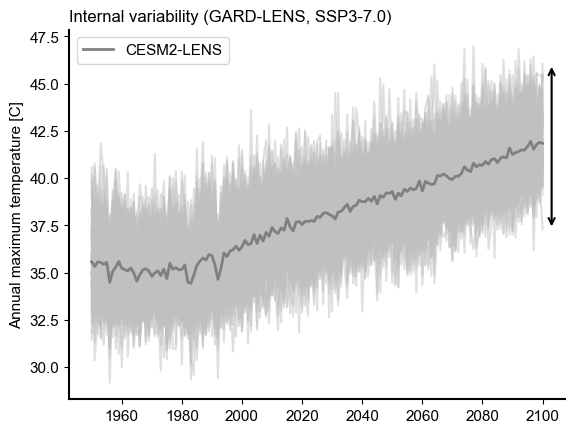

In [193]:
## Plot 3: internal variability
ensemble = 'GARD-LENS'
ssp = 'ssp370'
ssp_name = pu.ssp_labels[ssp]
gcm = 'CESM2-LENS'

df_gcm = df[(df['ssp'] == ssp) & (df['ensemble'] == ensemble) & (df['gcm'] == gcm)]

fig, ax = plt.subplots()

# Plot all
for member in df_gcm['member'].unique():
    df_plot_sel = df_gcm[df_gcm['member'] == member].sort_values('time')
    ax.plot(df_plot_sel['time'], df_plot_sel[var_id], color='silver', alpha=0.5)

# Add mean
df_gcm.groupby('time').mean(numeric_only=True)[var_id].plot(color='gray', label=gcm, lw=2)

# Tidy
ax.set_xlabel('')
ax.set_ylabel('Annual maximum temperature [C]')
ax.set_title(f'Internal variability (GARD-LENS, {ssp_name})', loc='left', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.legend()

# Add index of scenario uncertainty
y1 = df_gcm.query('time == 2100')[var_id].max()
y2 = df_gcm.query('time == 2100')[var_id].min()

ax.annotate('', xy=(2103, y1), xytext=(2103, y2),
            textcoords='data',
            arrowprops=dict(arrowstyle='<->', lw=1.5))

plt.show()

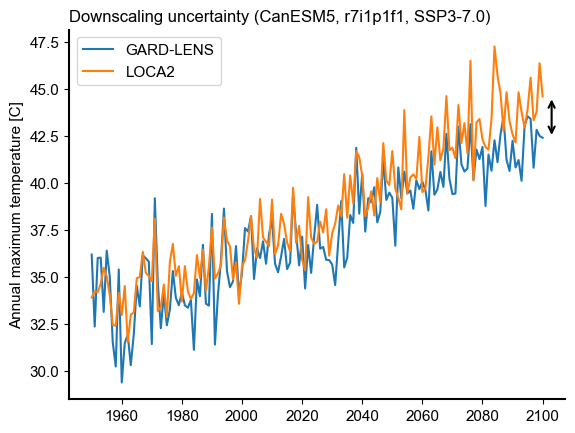

In [256]:
## Plot 4: downscaling uncertainty
gcm = 'CanESM5'
ssp = 'ssp370'
ssp_name = pu.ssp_labels[ssp]
ensemble1 = 'GARD-LENS'
ensemble2 = 'LOCA2'
member = 'r7i1p1f1'

df_ensemble1 = df[(df['ssp'] == ssp) & (df['ensemble'] == ensemble1) & (df['gcm'] == gcm) & (df['member'] == member)]
df_ensemble2 = df[(df['ssp'].isin([ssp, 'historical'])) & (df['ensemble'] == ensemble2) & (df['gcm'] == gcm) & (df['member'] == member)]

fig, ax = plt.subplots()

# Plot all
ax.plot(df_ensemble1['time'], df_ensemble1[var_id], label=ensemble1)
ax.plot(df_ensemble2['time'], df_ensemble2[var_id], label=ensemble2)

# Tidy
ax.set_xlabel('')
ax.set_ylabel('Annual maximum temperature [C]')
ax.set_title(f'Downscaling uncertainty ({gcm}, {member}, {ssp_name})', loc='left', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.legend()

# Add index of scenario uncertainty
y1 = df_ensemble1.query('time > 2099')[var_id].min()
y2 = df_ensemble2.query('time > 2099')[var_id].max()

ax.annotate('', xy=(2103, y1), xytext=(2103, y2),
            textcoords='data',
            arrowprops=dict(arrowstyle='<->', lw=1.5))

plt.show()

In [269]:
# Plot 5: GEV fit uncertainty 
ensemble = 'STAR-ESDM'
gcm = 'ACCESS-CM2'
ssp = 'ssp585'
member = 'r1i1p1f1'

df_sel = df[(df['gcm'] == gcm) & (df['ssp'] == ssp) & (df['ensemble'] == ensemble) & (df['member'] == member)]

# Robustness checks
stat_n_boot = 1000
nonstat_n_boot = 250
sample_str = ""
stat_fit_method = 'lmom'
nonstat_fit_method = 'mle'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
nonstat_slice = '1950-2100'

# Read both fits
df_stat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{stat_fit_method}_stat_nboot{stat_n_boot}{sample_str}.csv")
df_stat = df_stat[(df_stat['gcm'] == gcm) & (df_stat['ssp'] == ssp) & (df_stat['ensemble'] == ensemble) & (df_stat['member'] == member)]

df_nonstat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{nonstat_slice}_{nonstat_fit_method}_nonstat_nboot{nonstat_n_boot}{sample_str}.csv")
df_nonstat = df_nonstat[(df_nonstat['gcm'] == gcm) & (df_nonstat['ssp'] == ssp) & (df_nonstat['ensemble'] == ensemble) & (df_nonstat['member'] == member)]
df_nonstat_main = df_nonstat[df_nonstat['quantile'] == 'main']

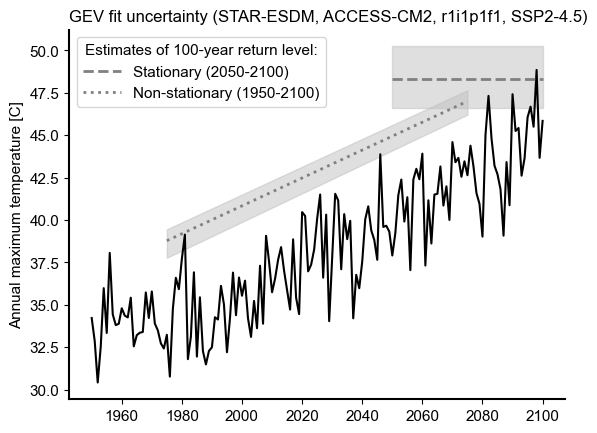

In [282]:
# Plot 5: GEV fit uncertainty 
fig, ax = plt.subplots()

col_name = "100yr_return_level"

# Main
ax.plot(df_sel['time'], df_sel[var_id], color="black")

# Proj
ax.fill_between(x = [2050, 2100],
                y1 = [df_stat[f"{col_name}_proj"].min()], 
                y2 = [df_stat[f"{col_name}_proj"].max()],
                color='silver', alpha=0.5)
ax.hlines(df_stat[f"{col_name}_proj"].median(), 2050, 2100, colors="gray", ls="--", lw=2,
          label = 'Stationary (2050-2100)')

# Non-stationary
times = [1975, 2075]
ax.plot(times, df_nonstat_main[[f"{col_name}_{year}" for year in [1975, 2075]]].to_numpy().flatten(),
        color="gray", ls="dotted", lw=2,
        label = 'Non-stationary (1950-2100)')

ax.fill_between(x=times,
                y1 = df_nonstat[[f"{col_name}_{year}" for year in [1975, 2075]]].max().to_numpy().flatten(),
                y2 = df_nonstat[[f"{col_name}_{year}" for year in [1975, 2075]]].min().to_numpy().flatten(),
                color="silver", alpha=0.5)

ax.set_xlabel('')
ax.set_ylabel('Annual maximum temperature [C]')
ax.set_title(f'GEV fit uncertainty ({ensemble}, {gcm}, {member}, {ssp_name})', fontsize=12, loc='left')
ax.spines[['right', 'top']].set_visible(False)
ax.legend(title='Estimates of 100-year return level:', handlelength=2.5)

plt.show()

### City plots

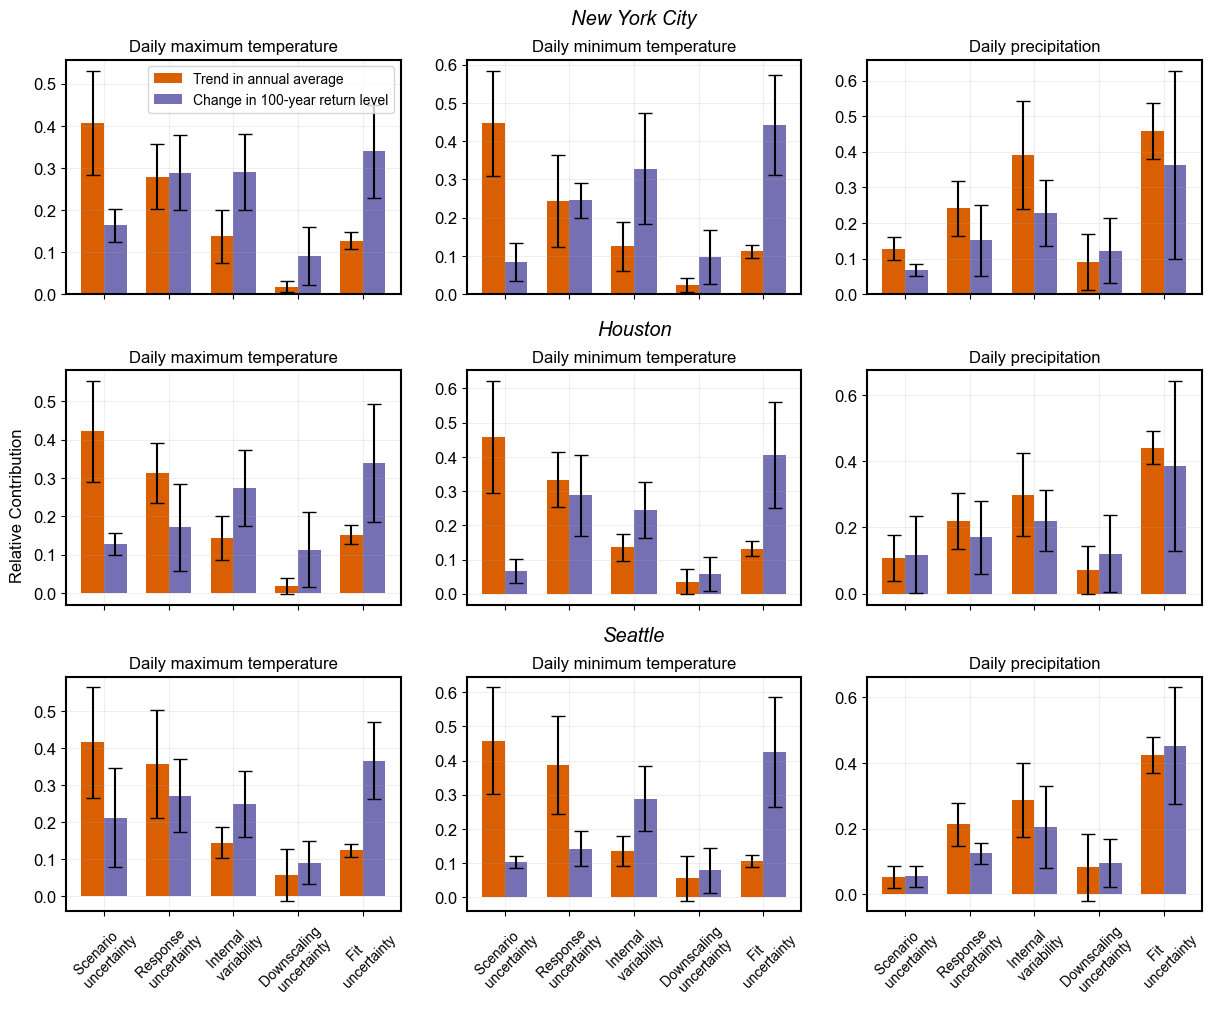

In [35]:
# Main plot
n_boot = 1000
sample_str = "_samples"
# GEV
stationary = 'stat'
fit_method = 'lmom'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
# Trend
trend_years = "2015-2100"

# Combined
cities = ['nyc', 'houston', 'seattle']
trend_metric_ids = ['avg_tasmax', 'avg_tasmin', 'sum_pr']
gev_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

metric_titles = {'tasmax': 'Daily maximum temperature', 
                 'tasmin': 'Daily minimum temperature', 
                 'pr': 'Daily precipitation'}

trend_label = "Trend in annual average"
gev_label = "Change in 100-year return level"

# Make figure
fig = plt.figure(figsize=(12, 10), layout='compressed')
gs = fig.add_gridspec(3, 3, hspace=0.05)

# Loop through cities
for idc, city in enumerate(cities):
    # Create city title
    ax_title = fig.add_subplot(gs[idc, :], frameon=False)
    ax_title.set_title(pu.city_names[city], fontstyle='italic', y=1.15, pad=0)
    ax_title.set_xticks([])
    ax_title.set_yticks([])

    # Loop through metrics
    for idm, (trend_metric_id, gev_metric_id) in enumerate(zip(trend_metric_ids, gev_metric_ids)):
        # Make axis
        ax = plt.subplot(gs[idc, idm])
        # Get variable
        assert trend_metric_id.split('_')[1] == gev_metric_id.split('_')[1], "variables are different"
        var_id = trend_metric_id.split('_')[1]
        
        # Read both datasets
        df_gev = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{gev_metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nboot{n_boot}{sample_str}.csv")
        df_gev_uc = sacu.calculate_df_uc(df_gev, '100yr_return_level_diff').set_index('uncertainty_type')
        
        df_trend = pd.read_csv(f"{project_data_path}/trends/cities/original_grid/{city}_{trend_metric_id}_{trend_years}_nboot{n_boot}{sample_str}.csv")
        df_trend_uc = sacu.calculate_df_uc(df_trend, 'slope').set_index('uncertainty_type')
        
        # Plot
        pu.plot_uc_bar(df_trend_uc = df_trend_uc, 
                       df_gev_uc = df_gev_uc, 
                       ax = ax, 
                       legend=(idc==0 and idm==0), 
                       trend_label = trend_label,
                       gev_label = gev_label
                      )
        
        # Add metric title to each subplot
        ax.set_title(metric_titles[var_id], fontsize=12)
        
        # Only show x-labels on bottom row
        if idc < 2:
            ax.set_xticklabels([])

# Add global y-label
fig.supylabel('Relative Contribution', fontsize=12)

# plt.tight_layout()
plt.savefig('../figs/main/figure4.pdf', bbox_inches='tight')

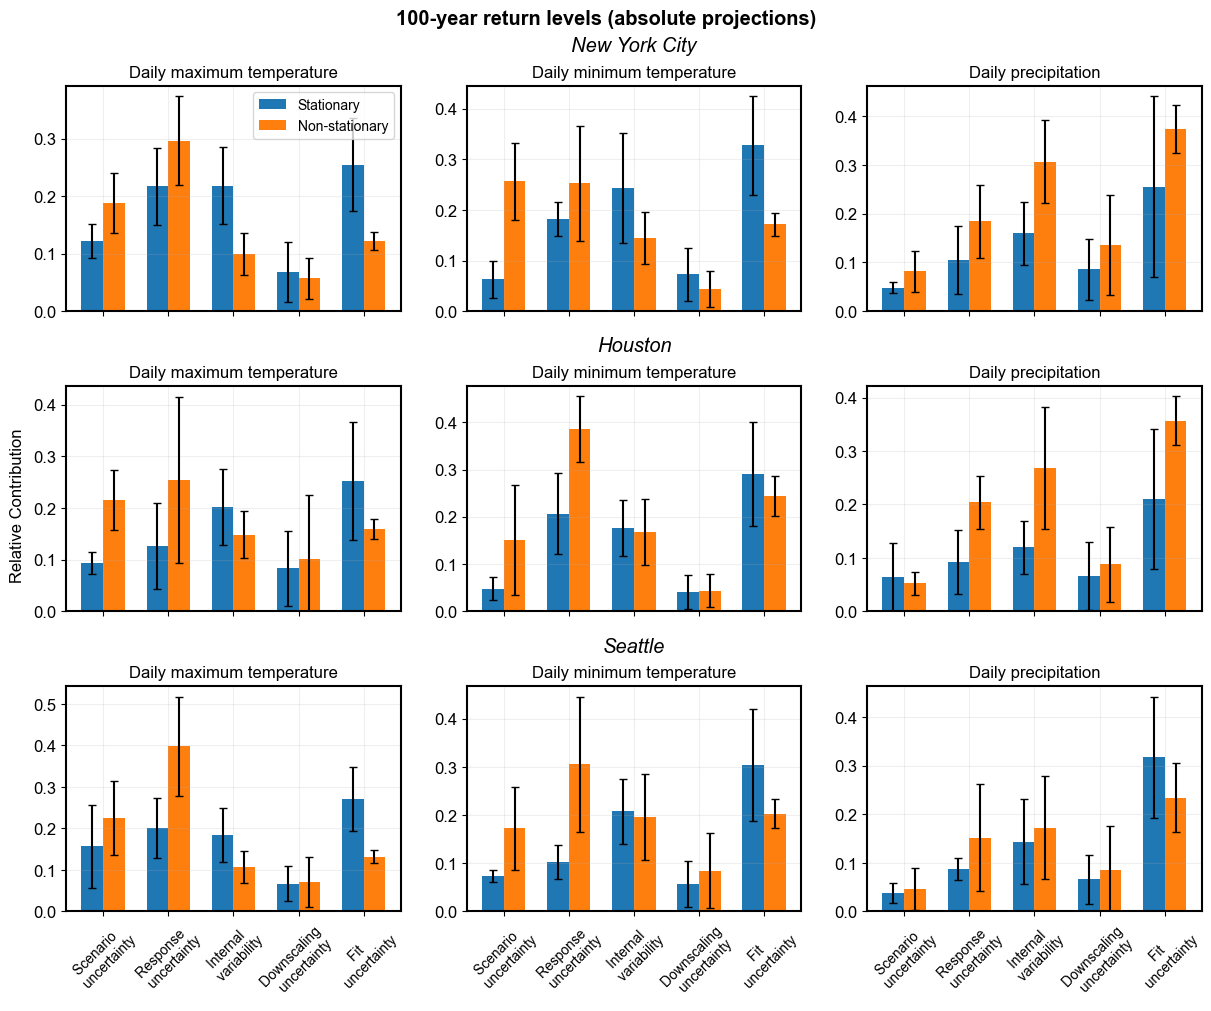

In [80]:
# Robustness checks
stat_n_boot = 1000
nonstat_n_boot = 250
sample_str = ""
stat_fit_method = 'lmom'
nonstat_fit_method = 'mle'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
nonstat_slice = '1950-2100'
nonstat_diff = '2075-1975'

stat_cols = ['100yr_return_level_proj', '100yr_return_level_diff']
nonstat_cols = [f'100yr_return_level_{nonstat_diff.split('-')[0]}', f'100yr_return_level_diff_{nonstat_diff}']

# Combined
cities = ['nyc', 'houston', 'seattle']
gev_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

metric_titles = {'tasmax': 'Daily maximum temperature', 
                 'tasmin': 'Daily minimum temperature', 
                 'pr': 'Daily precipitation'}

# Make figure
fig = plt.figure(figsize=(12, 10), layout='compressed')
gs = fig.add_gridspec(3, 3, hspace=0.05)

# Loop through cities
for idc, city in enumerate(cities):
    # Create city title
    ax_title = fig.add_subplot(gs[idc, :], frameon=False)
    ax_title.set_title(pu.city_names[city], fontstyle='italic', y=1.15, pad=0)
    ax_title.set_xticks([])
    ax_title.set_yticks([])

    # Loop through metrics
    for idm, gev_metric_id in enumerate(gev_metric_ids):
        # Make axis
        ax = plt.subplot(gs[idc, idm])
        # Get variable
        var_id = gev_metric_id.split('_')[1]
        
        # Read both datasets
        df_stat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{gev_metric_id}_{hist_slice}_{proj_slice}_{stat_fit_method}_stat_nboot{stat_n_boot}{sample_str}.csv")
        df_stat_uc_proj = sacu.calculate_df_uc(df_stat, '100yr_return_level_proj').set_index('uncertainty_type')
        df_stat_uc_diff = sacu.calculate_df_uc(df_stat, '100yr_return_level_diff').set_index('uncertainty_type')
        
        df_nonstat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{gev_metric_id}_{nonstat_slice}_{nonstat_fit_method}_nonstat_nboot{nonstat_n_boot}{sample_str}.csv")
        df_nonstat_uc_proj = sacu.calculate_df_uc(df_nonstat, f'100yr_return_level_{nonstat_diff.split('-')[0]}').set_index('uncertainty_type')
        df_nonstat_uc_diff = sacu.calculate_df_uc(df_nonstat, f'100yr_return_level_diff_{nonstat_diff}').set_index('uncertainty_type')
        
        # # Plot
        # pu.plot_uc_bars(dfs = [df_stat_uc_proj, df_stat_uc_diff, df_nonstat_uc_proj, df_nonstat_uc_diff],
        #                labels = ['Stationary (projection)', 'Stationary (change)', 'Non-stationary (projection)', 'Non-stationary (change)'],
        #                ax = ax, 
        #                legend=(idc==0 and idm==0))

        # Plot
        pu.plot_uc_bars(dfs = [df_stat_uc_diff, df_nonstat_uc_diff],
                       labels = ['Stationary', 'Non-stationary'],
                       ax = ax, 
                       legend=(idc==0 and idm==0))
        
        # Add metric title to each subplot
        ax.set_title(metric_titles[var_id], fontsize=12)
        
        # Only show x-labels on bottom row
        if idc < 2:
            ax.set_xticklabels([])

# Add global labels
fig.supylabel('Relative Contribution', fontsize=12)
fig.suptitle('100-year return levels (absolute projections)', fontweight='bold')

# plt.tight_layout()
plt.savefig('../figs/main/city_comparison_diff.pdf', bbox_inches='tight')
# plt.show()

### Other

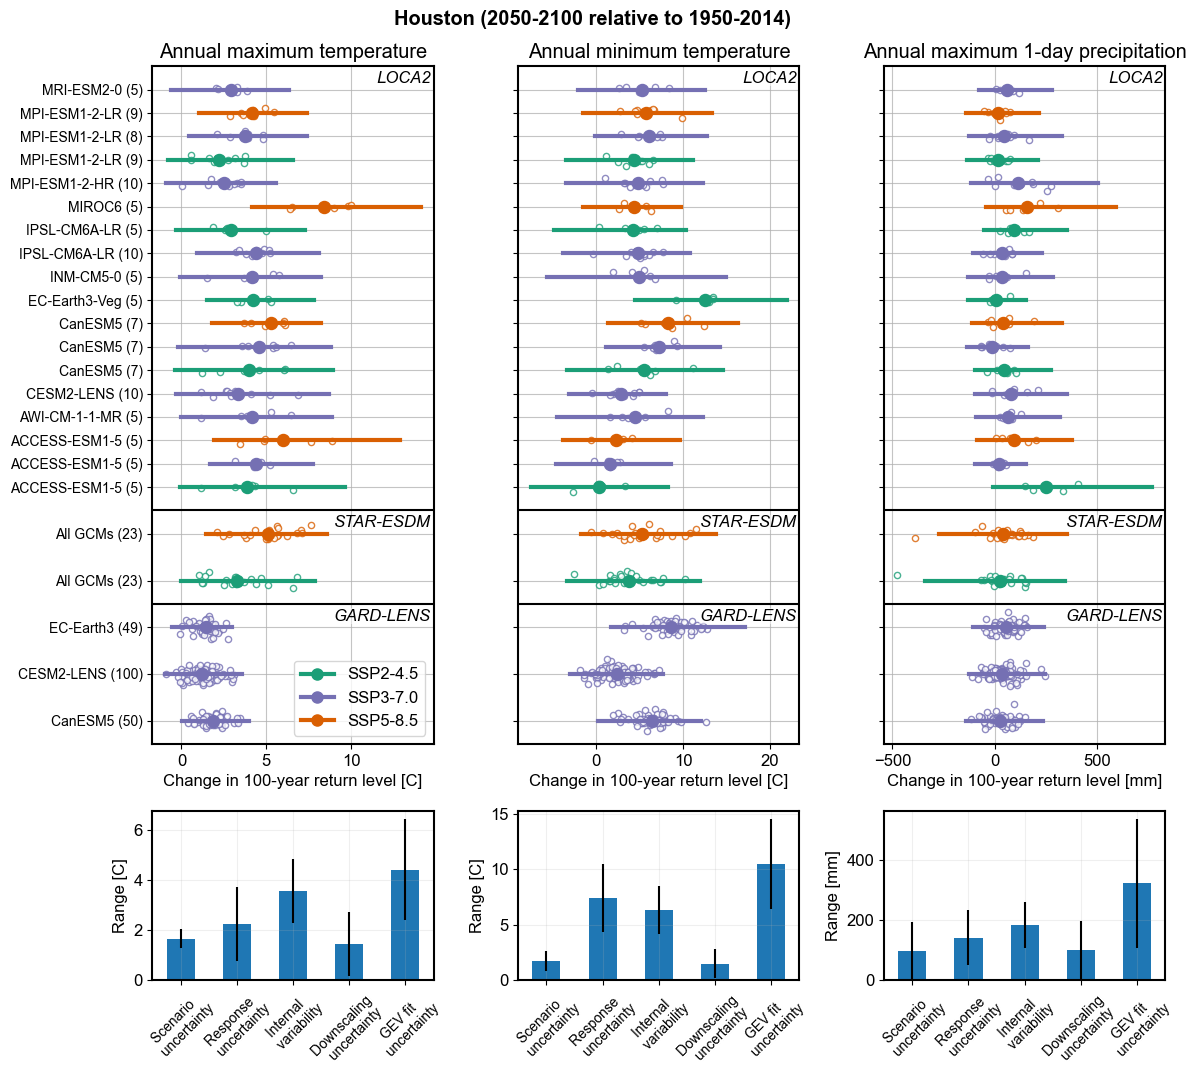

In [24]:
city = 'houston'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, read_samples=True)

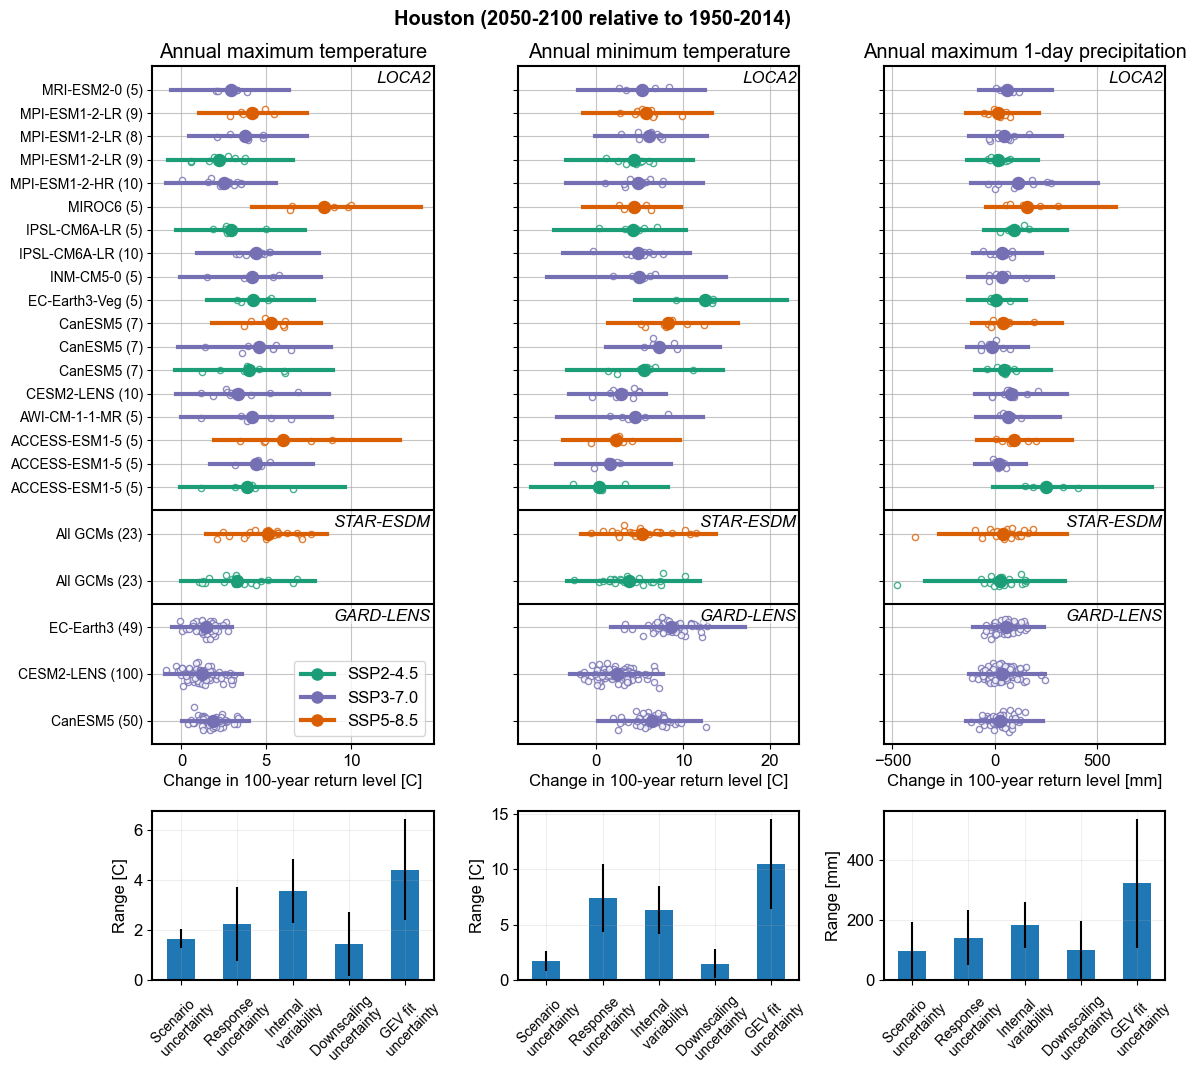

In [5]:
city = 'houston'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary)

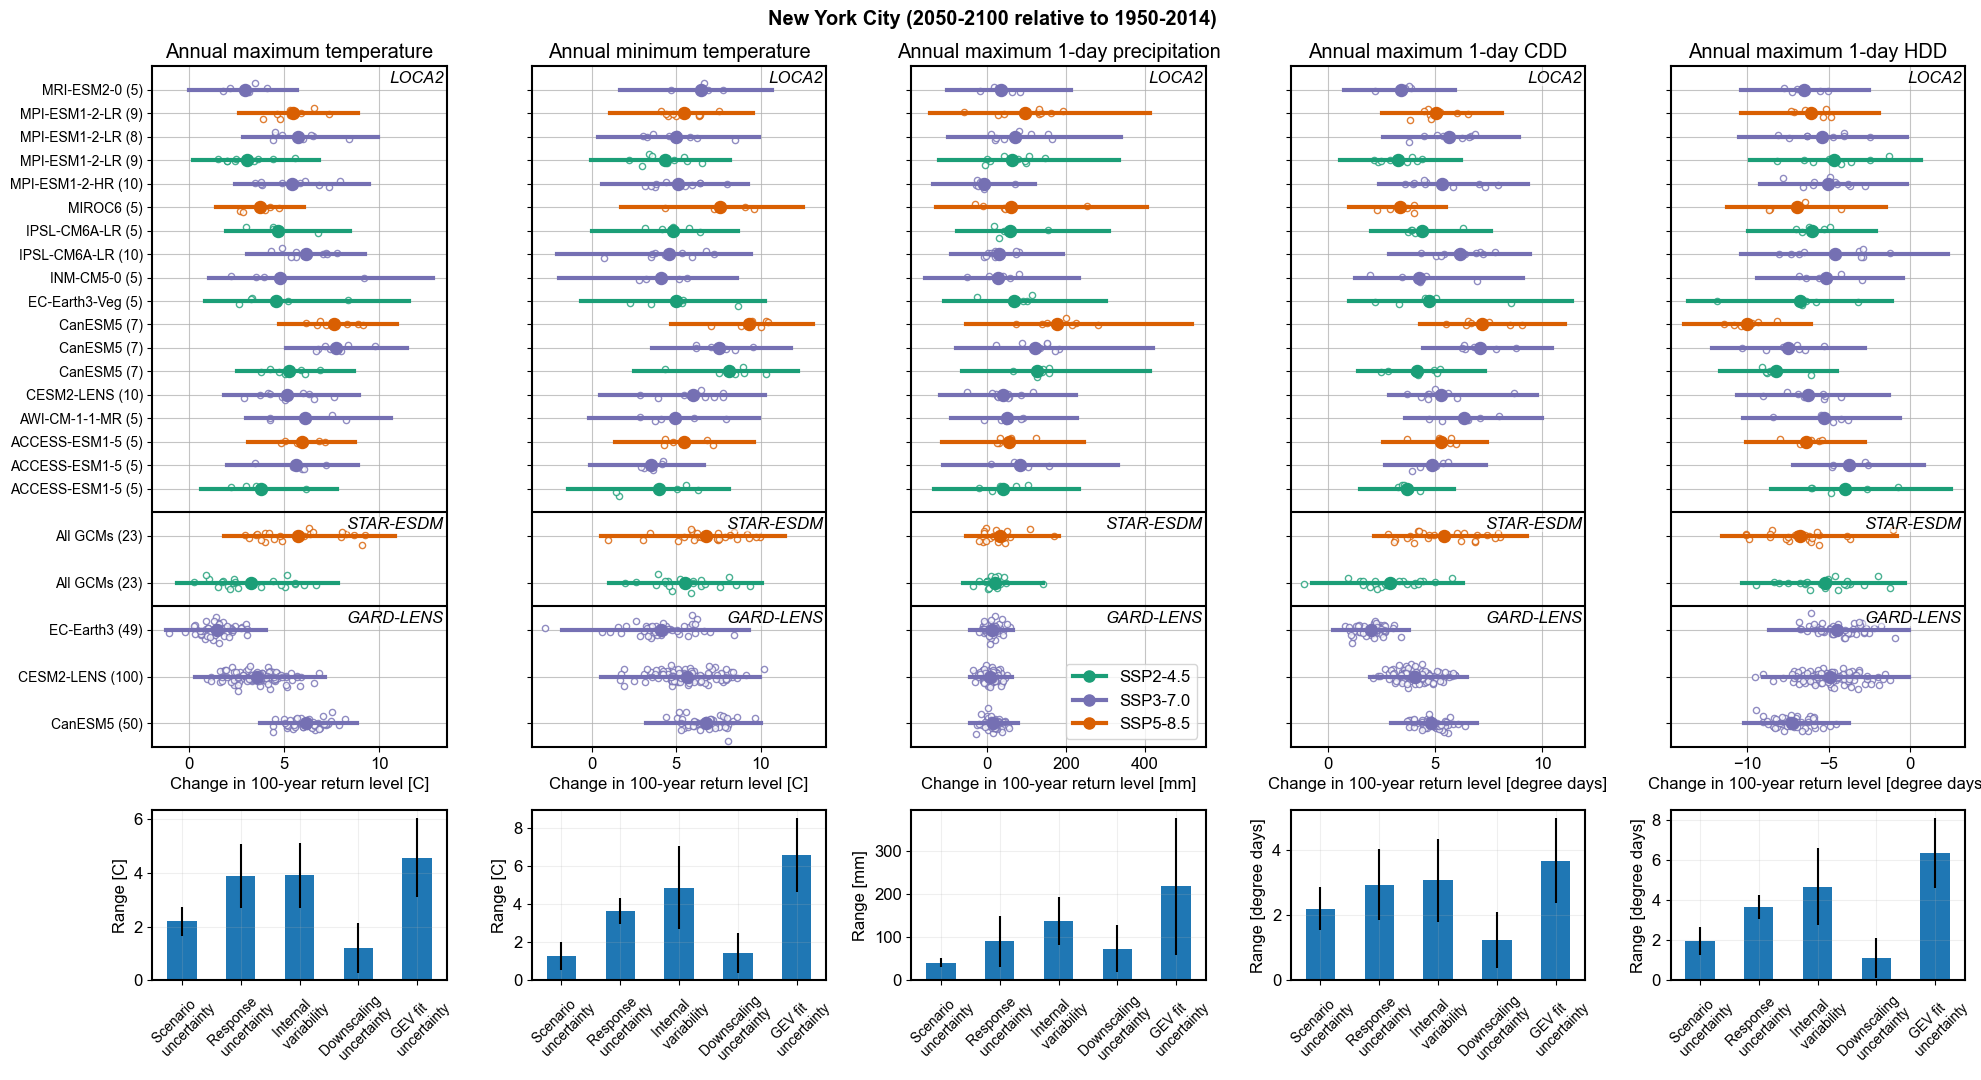

In [8]:
city = 'nyc'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr', 'max_cdd', 'max_hdd']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, legend=2)

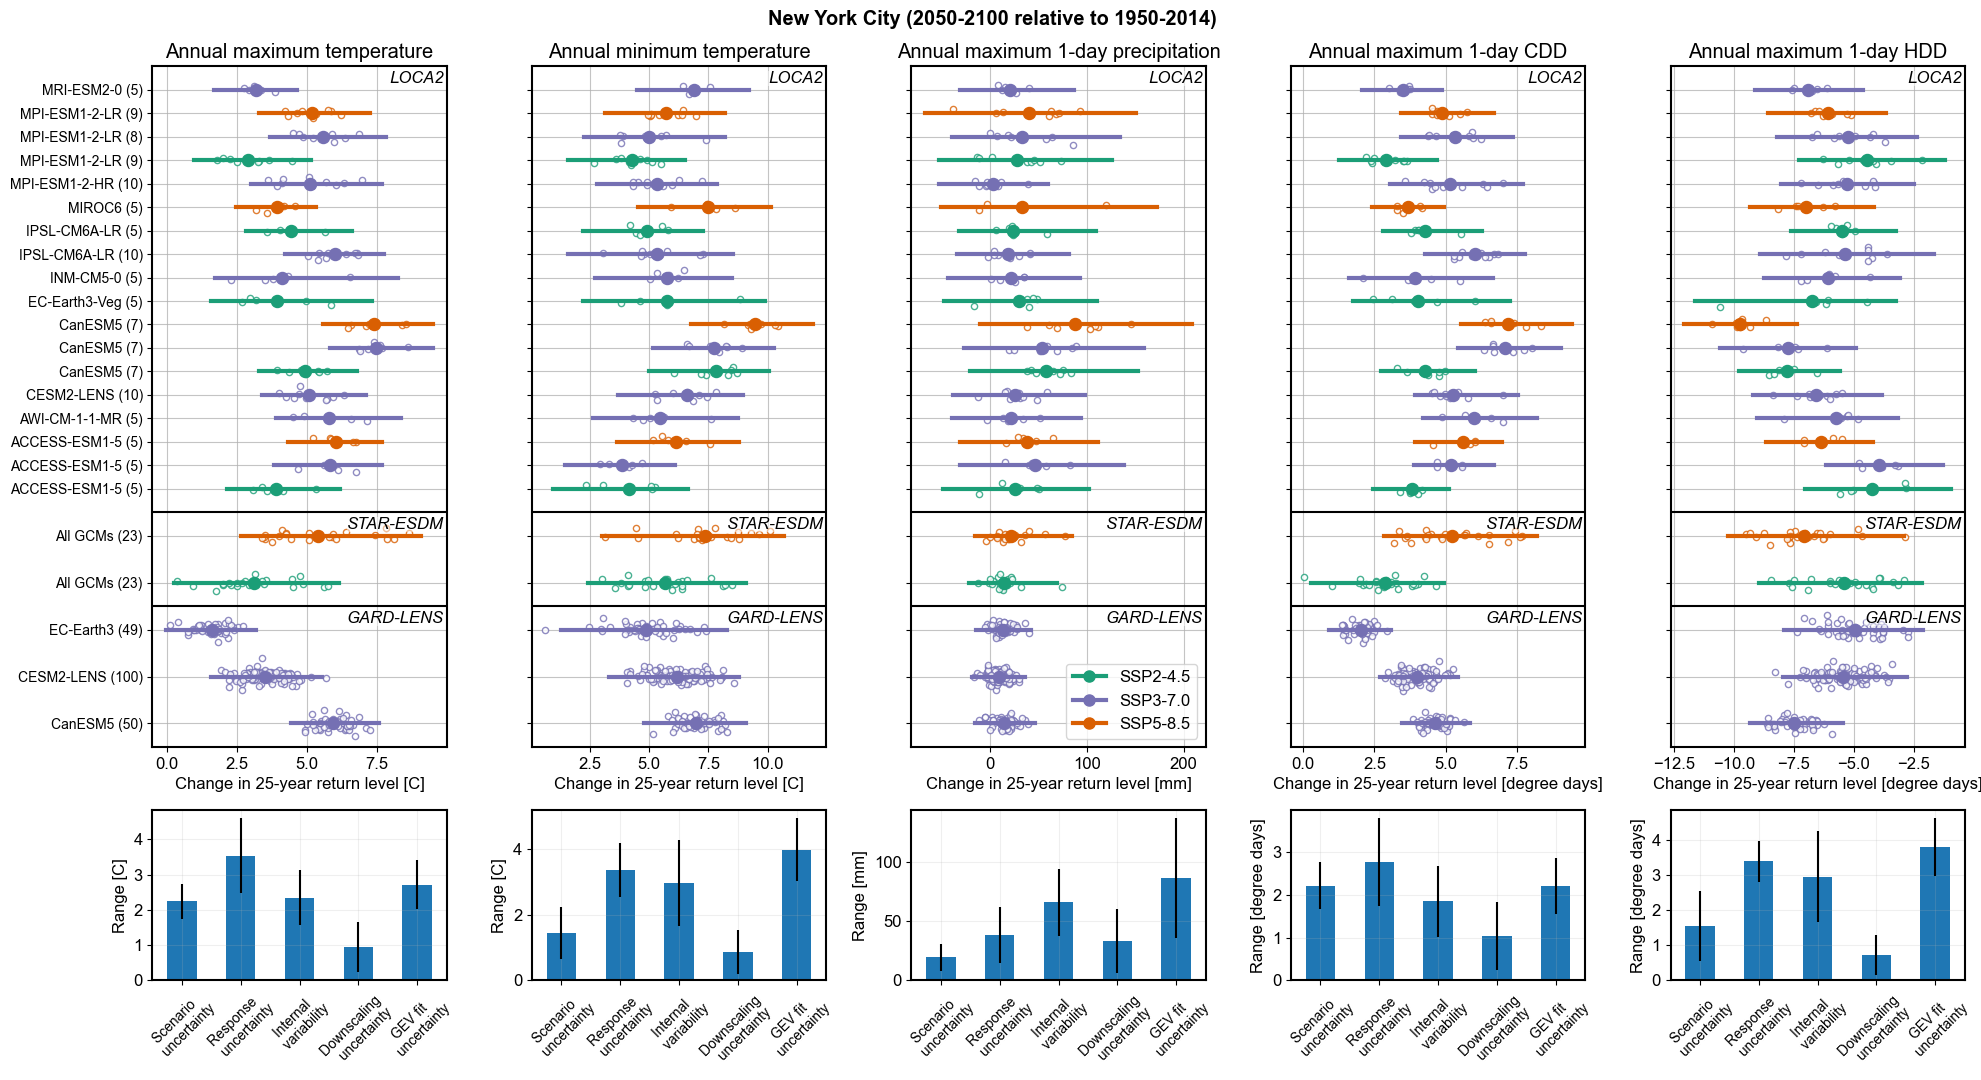

In [9]:
city = 'nyc'
plot_col = '25yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr', 'max_cdd', 'max_hdd']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, legend=2)